#  eCommerce Customer Segmentation (RFM Analysis)


## Table of Contents
<ul>
<li><a href="#exploratory"> Data Preprocessing and Exploratory Data Analysis</a></li>
<li><a href="#rfm">RFM Analysis</a></li>
<li><a href="#segmentation">Customer Segmentation with RFM Model</a></li>
<li><a href="#results">Results and Interpretations of RFM Analysis</a></li>
</ul>


In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from datetime import date as dt
%matplotlib inline

### Data Acquisition

In [80]:
# Load dataset and convert CustomerID & InvoiceID to string (better understandings)

df = pd.read_csv('/Users/wei-lin/Desktop/Projects/eCommerce/OnlineRetail.csv'
                 , encoding= 'unicode_escape',dtype={'CustomerID': str,'InvoiceID': str})

<a id='exploratory'></a>
## Data Preprocessing and Exploratory Data Analysis

In [82]:
print('Shape of the dataframe:',df.shape)

df.head()

Shape of the dataframe: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850,United Kingdom


### Data Cleansing  

In [4]:
# Display rows containing missing values 

null_data = df[df.isnull().any(axis=1)] #'any(axis=1)': Checking rows if any null values exists 
null_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,01-12-2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,01-12-2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,01-12-2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,01-12-2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,01-12-2010 14:32,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,09-12-2011 10:26,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,09-12-2011 10:26,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,09-12-2011 10:26,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,09-12-2011 10:26,10.79,NaN,United Kingdom


=> Out of total 541909 rows, 135080 rows containing missing values. 

In [5]:
# Check the sum of rows containing missing values and belongs to which column

print('Sum of rows having missing values: '+ str(df.isnull().sum()))

Sum of rows having missing values: InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [6]:
#Drop rows having missing values and print the size of the cleaned dataset

df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
print('Shape of the cleaned dataframe: ',df.shape)


Shape of the cleaned dataframe:  (406829, 8)


In [7]:
#Return the data types in the DataFrame

df.dtypes 

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID      object
Country         object
dtype: object

In [8]:
# Convert the datetime to proper datatypes (InvoiceDate)

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],format='%d-%m-%Y %H:%M')

df[['CustomerID','InvoiceDate']].head()

,CustomerID,InvoiceDate
0,17850,2010-12-01 08:26:00
1,17850,2010-12-01 08:26:00
2,17850,2010-12-01 08:26:00
3,17850,2010-12-01 08:26:00
4,17850,2010-12-01 08:26:00


In [9]:
# Generate descriptive statistics
df.describe()

,Quantity,UnitPrice
count,406829.000000,406829.000000
mean,12.061303,3.460471
std,248.693370,69.315162
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


In [10]:
# Return a Series containing counts of unique values for column 'Country'

df['Country'].value_counts()

United Kingdom          361878
Germany                   9495
France                    8491
EIRE                      7485
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               1877
Portugal                  1480
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
USA                        291
Israel                     250
Unspecified                244
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon                     45
Lithuani

=> Most of the orders are from the UK, then Germany and France respectively

<a id='rfm'></a>
## RFM Analysis 

RFM (Recency, Frequency, Monetary) analysis is a customer segmentation technique that uses past purchase behavior to divide customers into groups. RFM model helps divide customers into segments to identify customers who are more likely to respond to promotions and also for future personalized communications.

First, Create an RFM model to assign Recency, Frequency and Monetary values to each customer

- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)


In [11]:
# Attribute : Recency
# Compute the maximum date to know the last transaction date

max_date = max(df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [12]:
# Compute the difference between max date and transaction date

df['Recency'] = max_date - df['InvoiceDate']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Recency
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,373 days 04:24:00


In [13]:
# Compute last transaction date to get the recency of customers

rfm_r = df.groupby('CustomerID')['Recency'].min()
rfm_r = rfm_r.reset_index()
rfm_r.head()

,CustomerID,Recency
0,12346,325 days 02:33:00
1,12347,1 days 20:58:00
2,12348,74 days 23:37:00
3,12349,18 days 02:59:00
4,12350,309 days 20:49:00


In [14]:
# Extract only the number of days 

rfm_r['Recency'] = rfm_r['Recency'].dt.days
rfm_r.head()

,CustomerID,Recency
0,12346,325
1,12347,1
2,12348,74
3,12349,18
4,12350,309


In [15]:
# Attribute : Frequency
rfm_f = df.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346,2
1,12347,182
2,12348,31
3,12349,73
4,12350,17


In [16]:
# Attribute : Monetary 
df['Monetary'] = df['Quantity']*df['UnitPrice'] # Monetary = Amount = Price * Quantity
rfm_m = df.groupby('CustomerID')['Monetary'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Monetary
0,12346,0.00
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40


In [17]:
# Merge two dataframes (Recency and Frequency)

rfm_rf = pd.merge(rfm_r, rfm_f, on = 'CustomerID', how='inner')
rfm_rf[['CustomerID','Recency','Frequency']].head()

,CustomerID,Recency,Frequency
0,12346,325,2
1,12347,1,182
2,12348,74,31
3,12349,18,73
4,12350,309,17


In [18]:
# Merge all three dataframes to get the final RFM dataframe

rfm =pd.merge(rfm_rf, rfm_m, on='CustomerID', how='inner')
rfm[['CustomerID','Recency', 'Frequency', 'Monetary']].head()


,CustomerID,Recency,Frequency,Monetary
0,12346,325,2,0.00
1,12347,1,182,4310.00
2,12348,74,31,1797.24
3,12349,18,73,1757.55
4,12350,309,17,334.40


### Removing outliers 

Use "__Interquartile Range Method__ " to remove outliers.


Text(0.5, 0, 'Attributes')

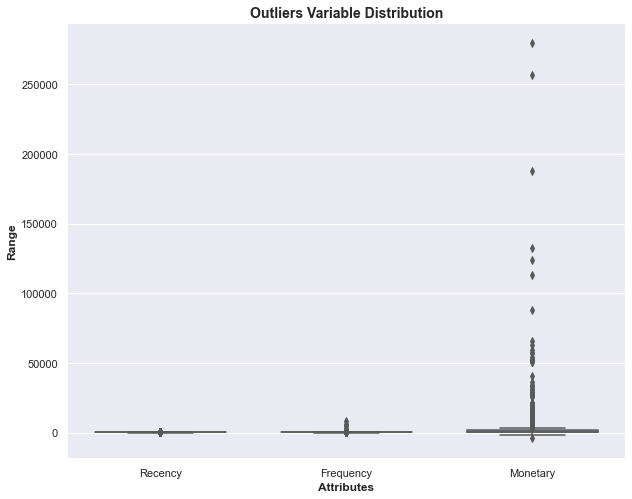

In [19]:
# Outlier Analysis of RFM ('Recency', 'Frequency' and 'Amount')

attributes = ['Recency','Frequency','Monetary']
plt.rcParams['figure.figsize'] = [10,8] # width and height = 10 and 8
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')


It is hard to see the range of Recency and Frequency; therefore, display these two attributes again.

Text(0.5, 0, 'Attributes')

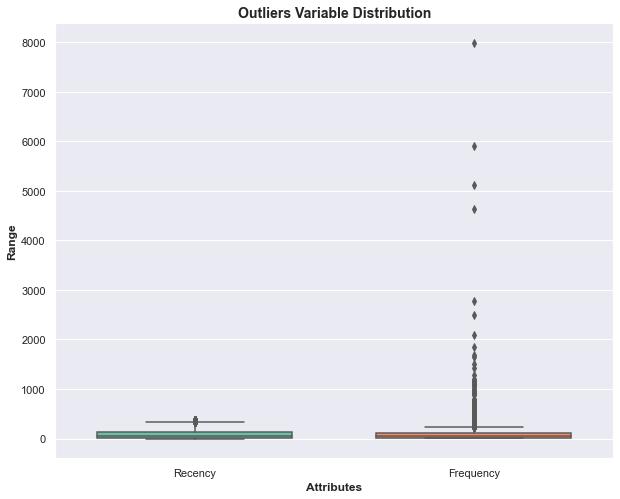

In [20]:
# Outlier Analysis of RFM ('Recency','Frequency')

attributes = ['Recency','Frequency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [21]:
# Interquartile Range Method

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Monetary
Q1 = rfm.Monetary.quantile(0.05)
Q3 = rfm.Monetary.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Monetary >= Q1 - 1.5*IQR) & (rfm.Monetary <= Q3 + 1.5*IQR)]


Text(0.5, 0, 'Attributes')

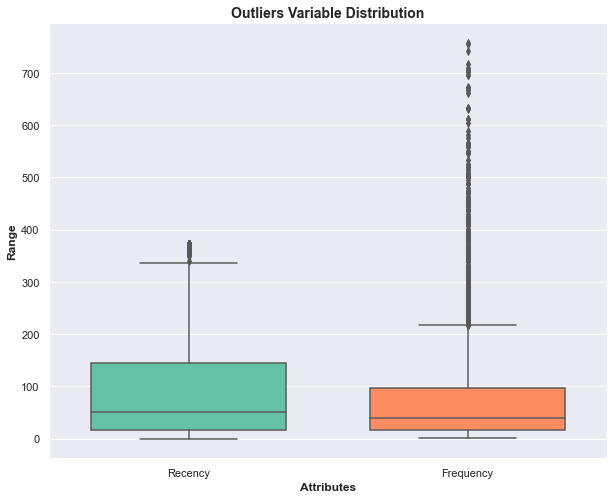

In [22]:
# Check again after removing statistical outliers, it shows outliers are removed

attributes = ['Recency','Frequency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

### RFM Model Verification

In [23]:
df[df['InvoiceNo']=='541432']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Recency,Monetary
61620,541432,21485,RETROSPOT HEART HOT WATER BOTTLE,3,2011-01-18 10:15:00,4.95,12748,United Kingdom,325 days 02:35:00,14.85
61621,541432,22457,NATURAL SLATE HEART CHALKBOARD,4,2011-01-18 10:15:00,2.95,12748,United Kingdom,325 days 02:35:00,11.80
61622,541432,84050,PINK HEART SHAPE EGG FRYING PAN,12,2011-01-18 10:15:00,1.65,12748,United Kingdom,325 days 02:35:00,19.80
61623,541432,22113,GREY HEART HOT WATER BOTTLE,30,2011-01-18 10:15:00,3.75,12748,United Kingdom,325 days 02:35:00,112.50


In [24]:
#df['Recency'] = max_date - df['InvoiceDate']
#df.head()

d0 = dt(2011,1,18) # trsaction data of InvoiceNo 541432
d1 = dt(2011,12,9) # last transaction date

delta = d1 - d0
delta.days

325

In [25]:
(dt(2011,12,9)-dt(2011,1,18)).days #last transaction date = 2011.12.9 

325

<a id='segmentation'></a>
## Customer segmentation with RFM Model


Second, divide customers into tiered groups for each of the three dimensions (R, F and M), it’s recommended to divide the customers into four tiers for each dimension. This results in 64 distinct customer segments (4x4x4), into which customers will be segmented. More sophisticated and less manual approaches – such as k-means cluster analysis – can be also performed, resulting in groups of customers with more homogeneous characteristics.


### RFM Quartiles 

In [89]:
rfm.describe()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile
count,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000
mean,92.604429,77.359674,1255.936448,2.485315,2.512354,2.500000
std,101.019718,100.508402,1700.085952,1.128240,1.124127,1.118373
min,0.000000,1.000000,-4287.630000,1.000000,1.000000,1.000000
25%,17.000000,17.000000,289.352500,1.000000,2.000000,1.250000
50%,50.000000,40.000000,632.220000,2.000000,3.000000,2.500000
75%,145.000000,97.000000,1516.785000,3.000000,4.000000,3.750000
max,373.000000,757.000000,12650.080000,4.000000,4.000000,4.000000


In [27]:
quantiles = rfm.quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,Monetary
0.25,17.0,17.0,289.3525
0.50,50.0,40.0,632.2200
0.75,145.0,97.0,1516.7850


Create segments according to RFM Quartiles:
Table 1.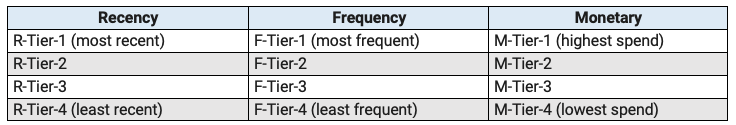

In [83]:
# Arguments for Recency (Lower is better)(x = value, p = recency, monetary_value, frequency, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

# Arguments for Frquency and Monetary (higher is better) (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [86]:
# Display RFM segmentation table

# Calculate R_Quartile, F_Quartile and M_Quartile scores for each customer 

rfm_seg = rfm
rfm_seg['R_Quartile'] = rfm_seg['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm_seg['F_Quartile'] = rfm_seg['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_seg['M_Quartile'] = rfm_seg['Monetary'].apply(FMScore, args=('Monetary',quantiles,))

# Combine these three scores into one "RFMScore"

rfm_seg['RFMScore'] = rfm_seg.R_Quartile.map(str) \
                            + rfm_seg.F_Quartile.map(str) \
                            + rfm_seg.M_Quartile.map(str)
rfm_seg.head()


,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
0,12346,325,2,0.00,4,4,4,444
1,12347,1,182,4310.00,1,1,1,111
2,12348,74,31,1797.24,3,3,1,331
3,12349,18,73,1757.55,2,2,1,221
4,12350,309,17,334.40,4,4,3,443


<a id='results'></a>
## Results and Interpretations

Finally, select groups of customers to whom specific types of communications will be sent, based on the RFM segments in which they appear. It is helpful to assign names to segments of interest.

__Best Customers__: Bought most recently, most often, and spend the most

In [87]:
rfm_seg[rfm_seg['RFMScore']=='111'].sort_values('Monetary', ascending=False).head(10)

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
1420,14258,8,112,12650.08,1,1,1,111
2438,15640,3,495,12433.34,1,1,1,111
561,13078,0,380,12432.28,1,1,1,111
2329,15498,0,523,12396.46,1,1,1,111
277,12682,3,525,12288.22,1,1,1,111
3090,16525,1,200,11895.57,1,1,1,111
3671,17340,8,424,11891.18,1,1,1,111
1675,14607,15,114,11341.10,1,1,1,111
1370,14194,4,604,11216.75,1,1,1,111
1883,14895,7,506,11020.26,1,1,1,111


List key segments and see which segments should be further analyzed. 

In [74]:
# Calculate the amount of customers in each segment

print('Best Customers:',len(rfm_seg[rfm_seg['RFMScore']=='111']))

print('New Customers: ',len(rfm_seg[rfm_seg['R_Quartile']==1])) #New customers

print('Loyal Customers: ',len(rfm_seg[rfm_seg['F_Quartile']==1])) #Loyal customers = Buy most frequently

print('Big Spenders: ',len(rfm_seg[rfm_seg['M_Quartile']==1])) #Spend the most

print('Lost Customers: ',len(rfm_seg[rfm_seg['RFMScore']=='444'])) #Last purchased was long time ago, purchased few, and spent little

Best Customers: 430
New Customers:  1122
Loyal Customers:  1065
Big Spenders:  1073
Lost Customers:  384


### Interpretations of initial analyses:

Table 2.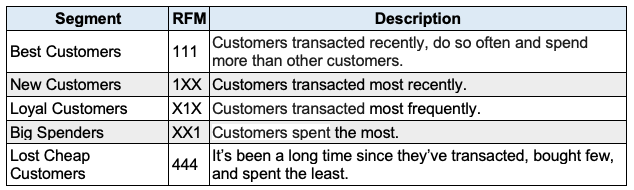

In [73]:
# Further analyze 

print('High-spending New Customers: ', len(rfm_seg[rfm_seg['RFMScore']=='141']+rfm_seg[rfm_seg['RFMScore']=='142']))

print('Lowest-Spending Active Loyal Customers  : ', len(rfm_seg[rfm_seg['RFMScore']=='113']+rfm_seg[rfm_seg['RFMScore']=='114']))

print('Churned Best Customers : ', len(rfm_seg[rfm_seg['RFMScore']=='411'] + rfm_seg[rfm_seg['RFMScore']=='412'] + rfm_seg[rfm_seg['RFMScore']=='421']+ rfm_seg[rfm_seg['RFMScore']=='422']))

High-spending New Customers:  19
Lowest-Spending Active Loyal Customers  :  21
Churned Best Customers :  120


### Interpretations of further analyses:

Now marketers know the customer segments, next step is to further segment customers and craft specific messaging that is tailored for each customer group. By focusing on the behavioral patterns of particular groups, RFM marketing allows marketers to communicate with customers in a much more effective manner.

Table 3.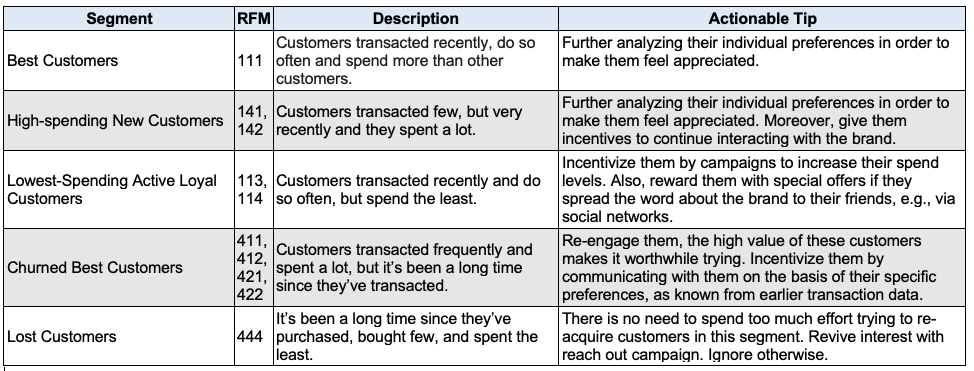